In [1]:
# Imports
%load_ext autoreload
%aimport sym
%autoreload 1
import os 
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
import torchvision
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sym import LCN, ProgressBar, Classification_report, Logger
from sym.utils import utils
from sym.utils.utils import cov_matrix, minmaxnorm
device = "cuda:0" if torch.cuda.is_available() else "cpu"
plt.style.use('dark_background')

In [2]:
trainset = torch.load("./data/trainset.pt")

In [3]:
filts = trainset.tensors[0].unfold(2,28,28).unfold(3,28,28).flatten(0,3)
filts = filts[(filts.flatten(1)>0).any(1)]

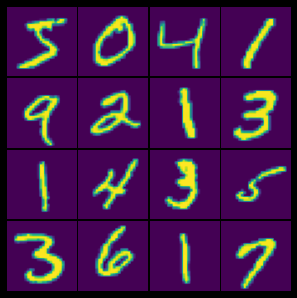

In [4]:
fig,axes = plt.subplots(4,4,figsize=(4,4))
for vec,ax in zip(filts,axes.flatten()):
    ax.imshow(vec.view(28,28).numpy())
    ax.axis("off")
fig.tight_layout(pad=0.2)

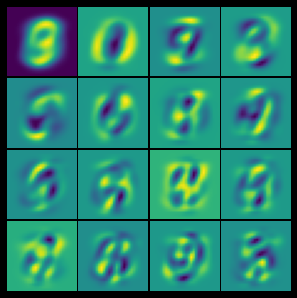

In [35]:
cov = cov_matrix(filts.float())
ev,evec = torch.eig(cov.float(),True)
evec = minmaxnorm(evec.T[:16])
fig,axes = plt.subplots(4,4,figsize=(4,4))
for vec,ax in zip(evec,axes.flatten()):
    ax.imshow(vec.view(28,28).numpy())
    ax.axis("off")
fig.tight_layout(pad=0.2)

In [7]:
# Load Model
params = {"in_channels":1,"out_channels":10,"h":280,"w":280,"nfilters":256,"hidden":64,"kernel_size":28,
          "stride":28,"readout_activation":None}
lr = 1e-6
weight_decay=1e-3
optim = torch.optim.Adam
module = sym.models.CNN(**params)
cnn = sym.models.Model(module,zeroparams=1e-5)
cnn.load_from_checkpoint("./lightning_logs/MNIST/DIAG/ADAM/weights/CNN/version_0/weights.cpkt-v0.ckpt", 
                         model = module, optim=optim(module.parameters(),weight_decay=weight_decay,lr=lr))

Model(
  (model): CNN(
    (activation): ReLU(inplace=True)
    (conv_blocks): Sequential(
      (0): Conv2d(1, 256, kernel_size=(28, 28), stride=(28, 28))
      (1): ReLU(inplace=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=25600, out_features=64, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=64, out_features=10, bias=True)
    )
  )
)

In [8]:
filts_cnn = list(cnn.model.conv_blocks.parameters())[0].detach().cpu()

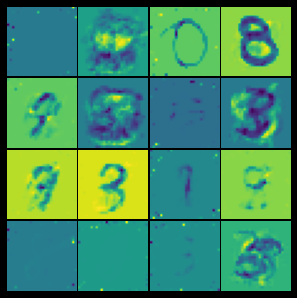

In [31]:
# CNN filters
fig,axes = plt.subplots(4,4,figsize=(4,4))
evec = minmaxnorm(filts_cnn)
for vec,ax in zip(evec,axes.flatten()):
    ax.imshow(vec.view(28,28).numpy())
    ax.axis("off")
fig.tight_layout(pad=0.2)

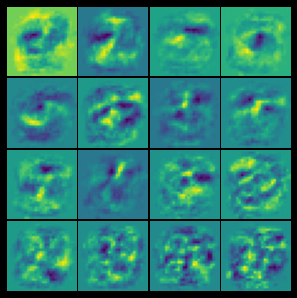

In [38]:
# Cov CNN Filters
cov_cnn = cov_matrix(filts_cnn.flatten(1))
ev,evec = torch.eig(cov_cnn,True)
fig,axes = plt.subplots(4,4,figsize=(4,4))
evec = minmaxnorm(evec.T[:16])
for vec,ax in zip(evec,axes.flatten()):
    ax.imshow(vec.view(28,28).numpy())
    ax.axis("off")
fig.tight_layout(pad=0.2)

In [11]:
from numpy import linalg
def pca(X):
    """  Principal Component Analysis
      input: X, matrix with training data stored as flattened arrays in rows
      return: projection matrix (with important dimensions first), variance
      and mean."""

    # get dimensions
    num_data, dim = X.shape

    # center data
    mean_X = X.mean(axis=0)
    X = X - mean_X

    if dim > num_data:
        # PCA - compact trick used
        M = dot(X, X.T)  # covariance matrix
        e, EV = linalg.eigh(M)  # eigenvalues and eigenvectors
        tmp = dot(X.T, EV).T  # this is the compact trick
        V = tmp[::-1]  # reverse since last eigenvectors are the ones we want
        S = sqrt(e)[::-1]  # reverse since eigenvalues are in increasing order
        for i in range(V.shape[1]):
            V[:, i] /= S
    else:
        # PCA - SVD used
        U, S, V = linalg.svd(X)
        V = V[:num_data]  # only makes sense to return the first num_data

    # return the projection matrix, the variance and the mean
    return V, S, mean_X

In [15]:
out = pca(cov.numpy())

In [18]:
out[0]

array([[ 2.8147265e-18,  1.1102230e-16,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 6.1110445e-18, -4.8572257e-17,  1.1102230e-16, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.4679650e-18, -1.1102230e-16,  5.5511151e-17, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  1.0000000e+00],
       [-9.9999774e-01, -3.1676693e-04, -9.6165313e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  8.1486040e-01, -3.0749941e-02, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)